Episode 100/500, Total Reward: 675.38, Exploration Rate: 0.0100
Episode 200/500, Total Reward: 668.02, Exploration Rate: 0.0100
Episode 300/500, Total Reward: 673.37, Exploration Rate: 0.0100
Episode 400/500, Total Reward: 673.07, Exploration Rate: 0.0100
Episode 500/500, Total Reward: 673.76, Exploration Rate: 0.0100


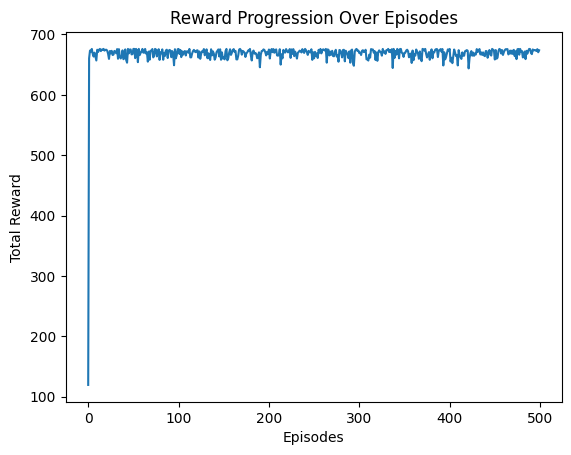

Action Distribution: {0: 116675, 1: 86626, 2: 699}


In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

# Market Environment for RL
class MarketEnvironment:
    def __init__(self, data, holding_period=5):
        self.data = data.reset_index()  # Ensure proper indexing
        self.current_step = 0
        self.done = False
        self.holding_period = holding_period  # Days to hold a position

    def reset(self):
        """Reset the environment to the initial state."""
        self.current_step = 0
        self.done = False
        return self.data.iloc[self.current_step][
            ['Temporal_Features', 'Price_Features', 'Upward_Downward_Probability', 'Cluster', 'Anomaly']
        ].values

    def step(self, action):
        """Perform an action and receive the next state, reward, and done flag."""
        current_close = self.data['Close'].iloc[self.current_step]
        
        # Calculate future close price based on holding period
        future_step = self.current_step + self.holding_period
        future_close = self.data['Close'].iloc[future_step] if future_step < len(self.data) else current_close

        # Reward logic
        if action == 0:  # Buy
            reward = future_close - current_close
        elif action == 1:  # Sell
            reward = current_close - future_close
        elif action == 2:  # Hold
            reward = -0.01  # Small penalty for inaction

        # Move to the next step
        self.current_step += 1
        if self.current_step >= len(self.data) - self.holding_period:
            self.done = True

        # Get the next state
        next_state = (
            self.data.iloc[self.current_step][
                ['Temporal_Features', 'Price_Features', 'Upward_Downward_Probability', 'Cluster', 'Anomaly']
            ].values
            if not self.done
            else None
        )
        return next_state, reward, self.done

# Q-Learning Agent
class QLearningAgent:
    def __init__(self, state_size, action_size, learning_rate=0.1, discount_factor=0.95, exploration_rate=1.0, exploration_decay=0.99, min_exploration=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.min_exploration = min_exploration
        self.q_table = {}

    def get_q_values(self, state):
        """Retrieve or initialize Q-values for the given state."""
        state_tuple = tuple(state)
        if state_tuple not in self.q_table:
            self.q_table[state_tuple] = np.zeros(self.action_size)
        return self.q_table[state_tuple]

    def choose_action(self, state):
        """Choose an action based on epsilon-greedy policy."""
        if np.random.rand() < self.exploration_rate:
            return np.random.choice(self.action_size)  # Explore
        q_values = self.get_q_values(state)
        return np.argmax(q_values)  # Exploit

    def learn(self, state, action, reward, next_state):
        """Update Q-values using the Q-learning formula."""
        state_tuple = tuple(state)
        next_state_tuple = tuple(next_state) if next_state is not None else None

        q_values = self.get_q_values(state)
        q_next = np.max(self.get_q_values(next_state)) if next_state_tuple else 0

        # Q-learning update formula
        q_values[action] += self.learning_rate * (reward + self.discount_factor * q_next - q_values[action])

        # Decay exploration rate
        self.exploration_rate = max(self.min_exploration, self.exploration_rate * self.exploration_decay)

# Training the RL Model
def train_rl(data, episodes=500, holding_period=5):
    env = MarketEnvironment(data, holding_period=holding_period)
    agent = QLearningAgent(state_size=5, action_size=3)  # 5 features, 3 actions (Buy, Sell, Hold)

    rewards_per_episode = []
    action_distribution = {0: 0, 1: 0, 2: 0}  # Track actions taken

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0

        while not env.done:
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.learn(state, action, reward, next_state)

            state = next_state
            total_reward += reward
            action_distribution[action] += 1

        rewards_per_episode.append(total_reward)

        # Print progress every 100 episodes
        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward:.2f}, Exploration Rate: {agent.exploration_rate:.4f}")

    return agent, rewards_per_episode, action_distribution

# Example Usage
if __name__ == "__main__":
    # Load data
    data = pd.read_csv('D:\Master_Folder\Data Science Course\Projects\StockMarket\stock_data/SUZLON.NS_2023-01-01_to_2024-11-21_ML.csv')

    # Train the RL agent
    holding_period = 1  # Holding period for swing trading (3 days in this case)
    trained_agent, rewards, action_dist = train_rl(data, episodes=500, holding_period=holding_period)

    # Plot rewards over episodes
    plt.plot(rewards)
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.title("Reward Progression Over Episodes")
    plt.show()

    # Display action distribution
    print("Action Distribution:", action_dist)
